# Delta hedging of a spread options

Consider a market model with two assets, a Bank account and a 2 Stocks with risk neutral dynamics:

$$
dB(t) = rB(t) dt, \hspace{10mm} B(0) = 1 \\
dS_1(t) = r S_1(t) dt + \sigma_1 S_1(t) dW_1(t), \hspace{10mm} S_1(0) = s_1 > 0 \\
dS_2(t) = r S_2(t) dt + \sigma_2 S_2(t) dW_2(t), \hspace{10mm} S_2(0) = s_2 > 0
$$

where $\sigma_1, \sigma_2 > 0$ and where $E[dW_1(t) dW_2(t)] = \rho dt$ is the correlation between the two Brownian motions.

Consider a spread option with that at time $T$ pays $X = (S_2(T) - S_1(T))^+$.

Chope the time interval between now (time 0) and expiry of the call-option (time $T$) into $N$ pieces; denote the discretization points $t_i$.  

In [21]:
import os
import sys
module_path = os.path.abspath(os.path.join('..\..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Discrete delta hedging experiment 

TODO: explain the delta hedhing strategy

In [22]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import vmap

from jaxfin.models.gbm import MultiGeometricBrownianMotion

from src.spread import margrabe_deltas, margrabe, margrabe_cross_gamma, margrabe_gammas
import scienceplots
plt.style.use(['science','no-latex'])

SEED = 42

In [23]:
s0 = jnp.array([100, 100])
means = jnp.array([0.1, 0.1])
vols = jnp.array([0.2, 0.3])
correlation = jnp.array([[1, 0.2], [0.2, 1]], dtype=jnp.float32)

gbm = MultiGeometricBrownianMotion(s0, means, vols, correlation, dtype=jnp.float32)

In [24]:
expiration = 1.0
N = 252
dt = expiration / N
n_simulation = 1

stock_path = gbm.simulate_paths(SEED, expiration, N, n_simulation)

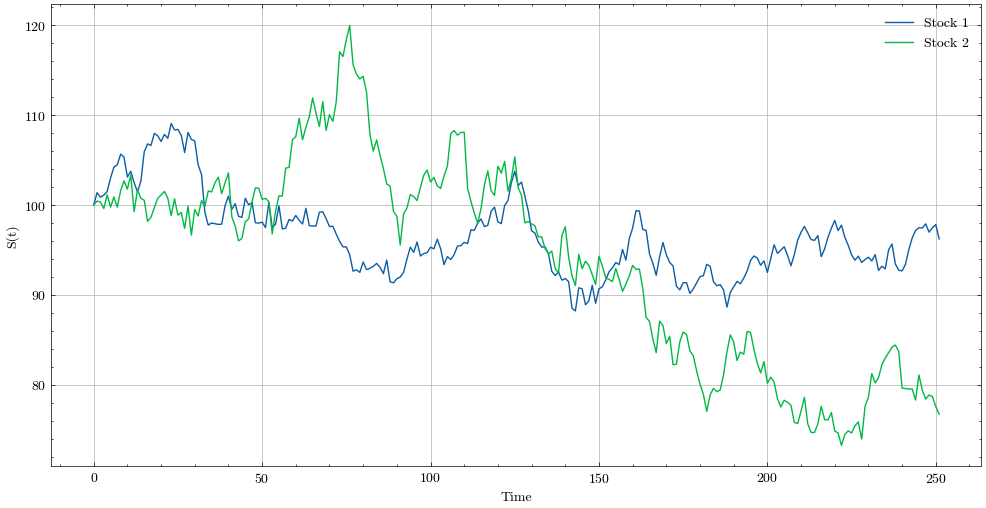

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(stock_path[:, :, 0], label='Stock 1')
plt.plot(stock_path[:, :, 1], label='Stock 2')
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.grid()
plt.legend()
plt.show()

In [26]:
deltas = jnp.asarray([margrabe_deltas(stock_path[i, 0, 0], stock_path[i, 0, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])
spread_value = jnp.asarray([margrabe(stock_path[i, 0, 0], stock_path[i, 0, 1], expiration- i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])
b = [spread_value[0] - deltas[0][0] * stock_path[0, 0, 0] - deltas[0][1] * stock_path[0, 0, 1]]
vs = [spread_value[0]]

for i in range(1, N):
    vs.append(deltas[i - 1][0] * stock_path[i, 0, 0] + deltas[i - 1][1] * stock_path[i, 0, 1] + b[i -1])
    b.append(vs[i] - deltas[i][0] * stock_path[i, 0, 0] - deltas[i][1] * stock_path[i, 0, 1])

hedge_error = jnp.asarray(vs) - jnp.maximum(stock_path[:, 0, 1] - stock_path[:, 0, 0], 0)

In [27]:
print('The final hedge error is: ', hedge_error[-1])

The final hedge error is:  -0.30664527


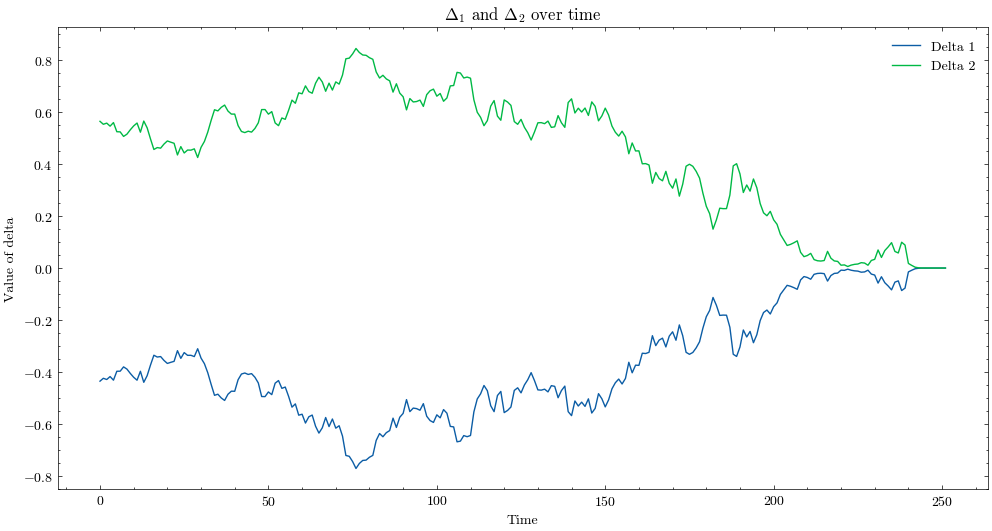

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(deltas[:, 0], label='Delta 1')
plt.plot(deltas[:, 1], label='Delta 2')
plt.title(r'$\Delta_1$ and $\Delta _2$ over time')
plt.xlabel('Time')
plt.ylabel('Value of delta')
plt.legend()
plt.show()

In [29]:
cross_gammas = jnp.asarray([margrabe_cross_gamma(stock_path[i, 0, 0], stock_path[i, 0, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])
gammas = jnp.asarray([margrabe_gammas(stock_path[i, 0, 0], stock_path[i, 0, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])

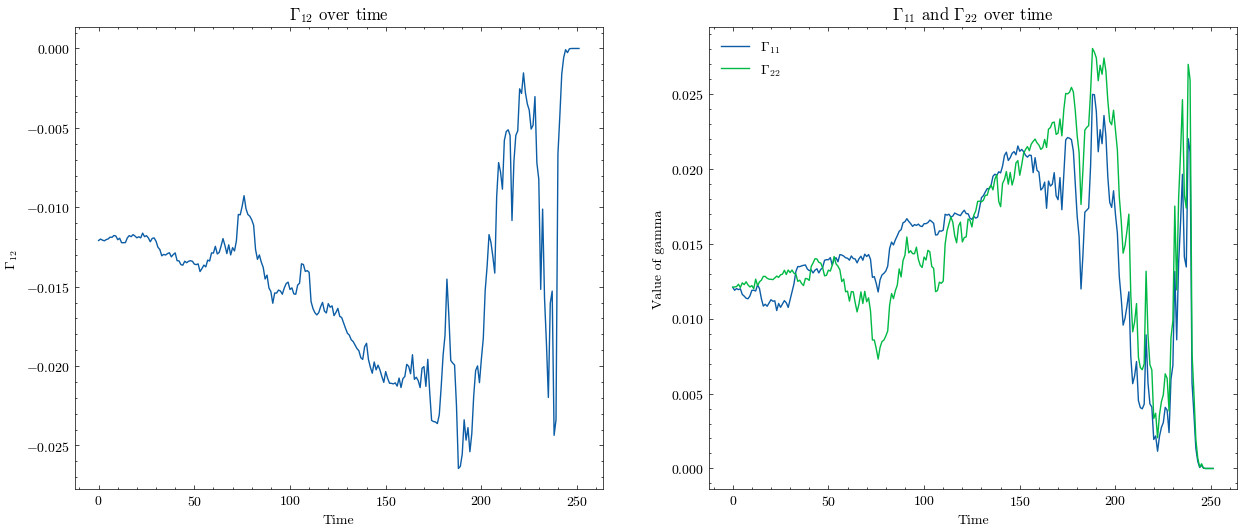

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(cross_gammas[:, 0])
axs[0].set_title(r'$\Gamma_{12}$ over time')
axs[0].set_xlabel('Time')
axs[0].set_ylabel(r'$\Gamma_{12}$')

axs[1].plot(gammas[:, 0], label=r'$\Gamma_{11}$')
axs[1].plot(gammas[:, 1], label=r'$\Gamma_{22}$')
axs[1].set_title(r'$\Gamma_{11}$ and $\Gamma_{22}$ over time')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Value of gamma')
axs[1].legend()

plt.show()

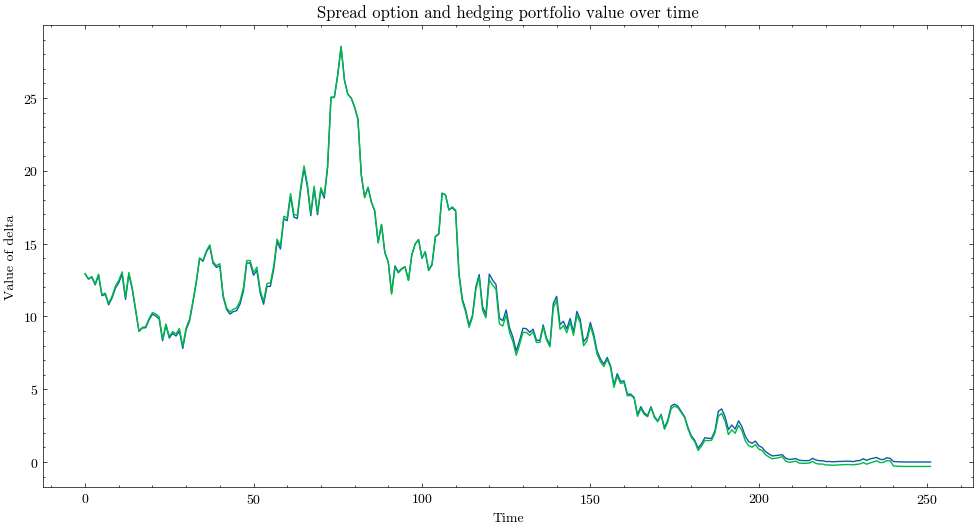

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(spread_value, label='Spread option')
plt.plot(vs, label='Hedging Portfolio')
plt.title('Spread option and hedging portfolio value over time')
plt.xlabel('Time')
plt.ylabel('Value of delta')
plt.show()

## Multiple simulations

In [32]:
n_simulation = 1000

stock_paths = gbm.simulate_paths(SEED, expiration, N, n_simulation)

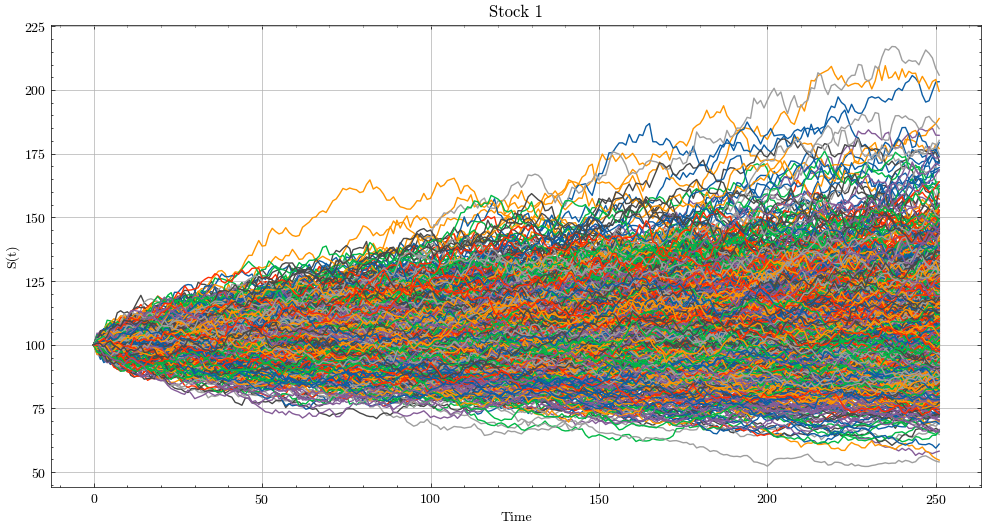

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(stock_paths[:, :, 0])
plt.title('Stock 1')
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.grid()
plt.show()

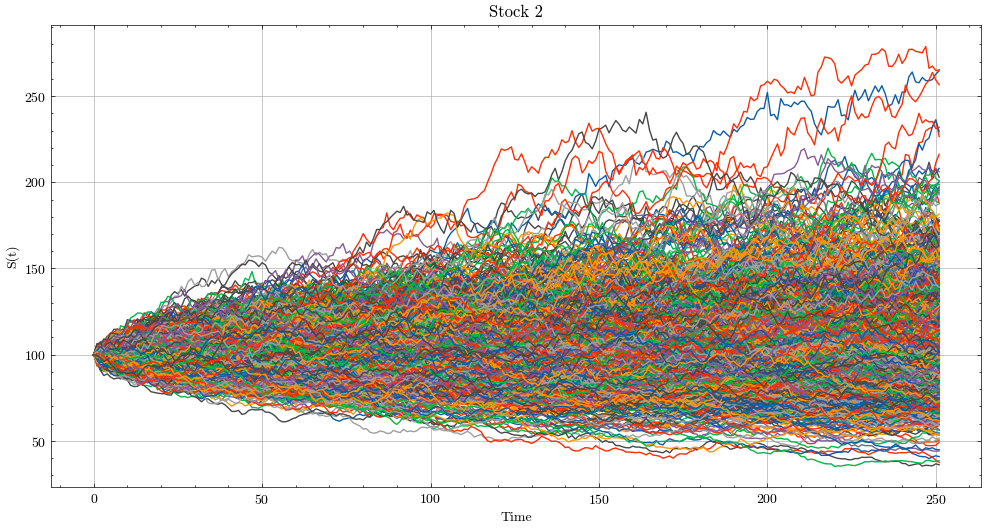

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(stock_paths[:, :, 1])
plt.title('Stock 2')
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.grid()
plt.show()

In [35]:
vmap_deltas = vmap(margrabe_deltas, in_axes=(0, 0, None, None, None, None))

In [36]:
deltas = jnp.asarray([vmap_deltas(stock_paths[i, :, 0], stock_paths[i, :, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])
spread_value = jnp.asarray([margrabe(stock_paths[i, :, 0], stock_paths[i, :, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])
b = [spread_value[0, :] - deltas[0, 0, :] * stock_paths[0, :, 0] - deltas[0, 1, :] * stock_paths[0, :, 1]]
vs = [spread_value[0, :]]

for i in range(1, N):
    vs.append(deltas[i - 1, 0, :] * stock_paths[i, :, 0] + deltas[i - 1, 1, :] * stock_paths[i, :, 1] + b[i - 1])
    b.append(vs[i] - deltas[i, 0, :] * stock_paths[i, :, 0] - deltas[i, 1, :] * stock_paths[i, :, 1])

hedge_error = jnp.asarray(vs)[-1] - jnp.maximum(stock_paths[-1:, :, 1] - stock_paths[-1:, :, 0], 0)

In [37]:
print(f"The mean hedge error is: {jnp.mean(hedge_error[-1, :]):.5f}")
print(f"The standard deviation of the hedge error is: {(jnp.std(hedge_error[-1, :]) / spread_value[0,0 ]):.5f}")

The mean hedge error is: 0.14023
The standard deviation of the hedge error is: 0.06059
